In [2]:
!pip install librosa


  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.61.2-cp313-cp313-win_amd64.whl.metadata (2.8 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached msgpack-1.1.1-cp313-cp313-win_amd64.whl.metadata (8.6 kB)
  Using cached standard_aifc-3.13.0-py3-none-any.whl.metadata (969 bytes)
  Using cached standard_sunau-3.13.0-py3-none-any.whl.metadata (914 bytes)
  Using cached llvmlite-0.44.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
  Using cached numpy-2.2.6-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached standard_chunk-3.13.0-py3-none-any.whl.metadata (860 bytes)
  Using cached audioop_lts-0.2.2-cp313-abi3-win_amd64.whl.metadata (2.0 kB)
U

In [1]:
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


In [11]:
DATASET_PATH = r"C:\Users\chara\OneDrive\Desktop\sample_project\Music Genre Classification\genres"


In [12]:

AUDIO_EXTS = ('.wav', '.WAV', '.au', '.mp3')
assert DATASET_PATH != "YOUR_DATASET_PATH", "Please set DATASET_PATH to your local GTZAN path before continuing."


In [13]:

def extract_features(file_path, duration=30, n_mfcc=20):
 
    try:
        y, sr = librosa.load(file_path, duration=duration, mono=True)
        # Guard for very short/empty files
        if y is None or len(y) < sr:
            return None
        
        # MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        
        # Spectral Contrast
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Tonnetz uses harmonic component
        y_harm = librosa.effects.harmonic(y)
        tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
        
        # Temporal pooling: mean & std for each feature map
        def agg_stats(mat):
            mat = mat.T  # (time, features)
            return np.hstack([np.mean(mat, axis=0), np.std(mat, axis=0)])
        
        feats = np.hstack([
            agg_stats(mfcc),
            agg_stats(mfcc_delta),
            agg_stats(mfcc_delta2),
            agg_stats(chroma),
            agg_stats(spec_contrast),
            agg_stats(tonnetz),
        ])
        return feats.astype(np.float32)
    except Exception as e:
        print(f"[WARN] Failed on {file_path}: {e}")
        return None


Example file: C:\Users\chara\OneDrive\Desktop\sample_project\Music Genre Classification\genres\blues\blues.00000.au


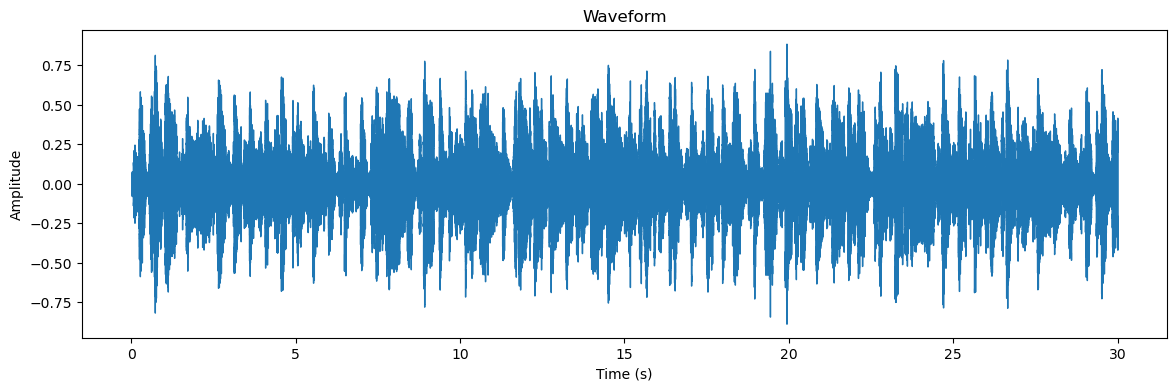

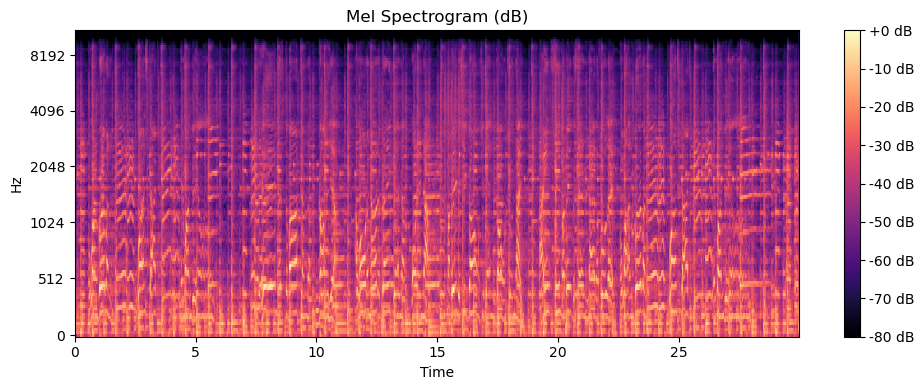

In [14]:

# Pick one example file to visualize
genre_folders = [g for g in sorted(os.listdir(DATASET_PATH)) if os.path.isdir(os.path.join(DATASET_PATH, g))]
assert len(genre_folders) >= 2, "No genre folders found. Ensure DATASET_PATH contains subfolders like 'blues', 'classical', ..."

# Find first available audio file
example_file = None
for g in genre_folders:
    gpath = os.path.join(DATASET_PATH, g)
    for fn in os.listdir(gpath):
        if fn.endswith(AUDIO_EXTS):
            example_file = os.path.join(gpath, fn)
            break
    if example_file:
        break

assert example_file is not None, "No audio files found in the genre subfolders."
print("Example file:", example_file)

y, sr = librosa.load(example_file, duration=30, mono=True)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (dB)")
plt.tight_layout()
plt.show()


In [15]:

# Build feature matrix X and label vector y
# Cache to speed up repeated runs
FEATURES_NPY = "features_X.npy"
LABELS_NPY = "labels_y.npy"
FEATURES_CSV = "features_table.csv"

if os.path.exists(FEATURES_NPY) and os.path.exists(LABELS_NPY):
    print("Loading cached features...")
    X = np.load(FEATURES_NPY)
    y = np.load(LABELS_NPY)
else:
    X_list, y_list = [], []
    for g in genre_folders:
        gpath = os.path.join(DATASET_PATH, g)
        files = [os.path.join(gpath, fn) for fn in os.listdir(gpath) if fn.endswith(AUDIO_EXTS)]
        files = sorted(files)
        print(f"Extracting {g:>10}: {len(files)} files")
        
        for fp in files:
            feats = extract_features(fp)
            if feats is not None:
                X_list.append(feats)
                y_list.append(g)
    
    X = np.vstack(X_list)
    y = np.array(y_list)

    np.save(FEATURES_NPY, X)
    np.save(LABELS_NPY, y)
    # Also save a CSV for inspection (with labels)
    df = pd.DataFrame(X)
    df['label'] = y
    df.to_csv(FEATURES_CSV, index=False)
    print(f"Saved cached features to {FEATURES_NPY}, {LABELS_NPY}, and {FEATURES_CSV}")

print("X shape:", X.shape, " y shape:", y.shape)
print("Classes:", sorted(set(y)))


Extracting      blues: 100 files
Extracting  classical: 100 files
Extracting    country: 100 files
Extracting      disco: 100 files
Extracting     hiphop: 100 files
Extracting       jazz: 100 files
Extracting      metal: 100 files
Extracting        pop: 100 files
Extracting     reggae: 100 files
Extracting       rock: 100 files
Saved cached features to features_X.npy, labels_y.npy, and features_table.csv
X shape: (1000, 170)  y shape: (1000,)
Classes: [np.str_('blues'), np.str_('classical'), np.str_('country'), np.str_('disco'), np.str_('hiphop'), np.str_('jazz'), np.str_('metal'), np.str_('pop'), np.str_('reggae'), np.str_('rock')]


In [16]:

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Scale features (very important for MLP)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print("Train size:", X_train_sc.shape, " Test size:", X_test_sc.shape)


Train size: (800, 170)  Test size: (200, 170)


RandomForest Accuracy: 0.7550

RandomForest Classification Report:
               precision    recall  f1-score   support

       blues       0.86      0.90      0.88        20
   classical       0.86      0.95      0.90        20
     country       0.71      0.85      0.77        20
       disco       0.62      0.50      0.56        20
      hiphop       0.75      0.90      0.82        20
        jazz       0.76      0.80      0.78        20
       metal       0.85      0.85      0.85        20
         pop       0.74      0.85      0.79        20
      reggae       0.69      0.55      0.61        20
        rock       0.62      0.40      0.48        20

    accuracy                           0.76       200
   macro avg       0.75      0.76      0.74       200
weighted avg       0.75      0.76      0.74       200



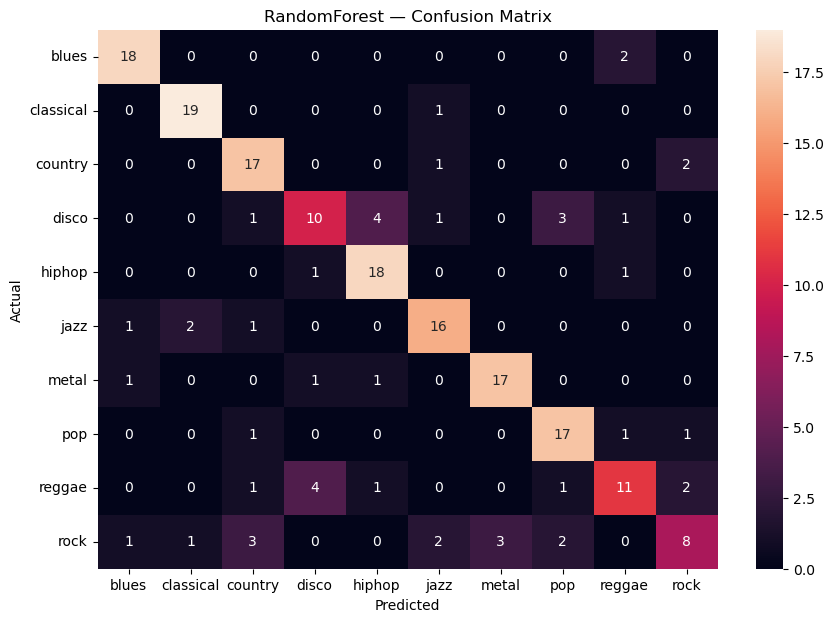

In [17]:

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # RF works fine without scaling

rf_pred = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"RandomForest Accuracy: {rf_acc:.4f}")
print("\nRandomForest Classification Report:\n", classification_report(y_test, rf_pred, target_names=le.classes_))

rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(10,7))
sns.heatmap(rf_cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RandomForest — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


MLPClassifier Accuracy: 0.6900

MLPClassifier Classification Report:
               precision    recall  f1-score   support

       blues       0.76      0.65      0.70        20
   classical       0.90      0.90      0.90        20
     country       0.63      0.85      0.72        20
       disco       0.50      0.35      0.41        20
      hiphop       0.58      0.95      0.72        20
        jazz       0.78      0.90      0.84        20
       metal       0.68      0.85      0.76        20
         pop       0.71      0.75      0.73        20
      reggae       0.62      0.40      0.48        20
        rock       0.86      0.30      0.44        20

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.67       200
weighted avg       0.70      0.69      0.67       200



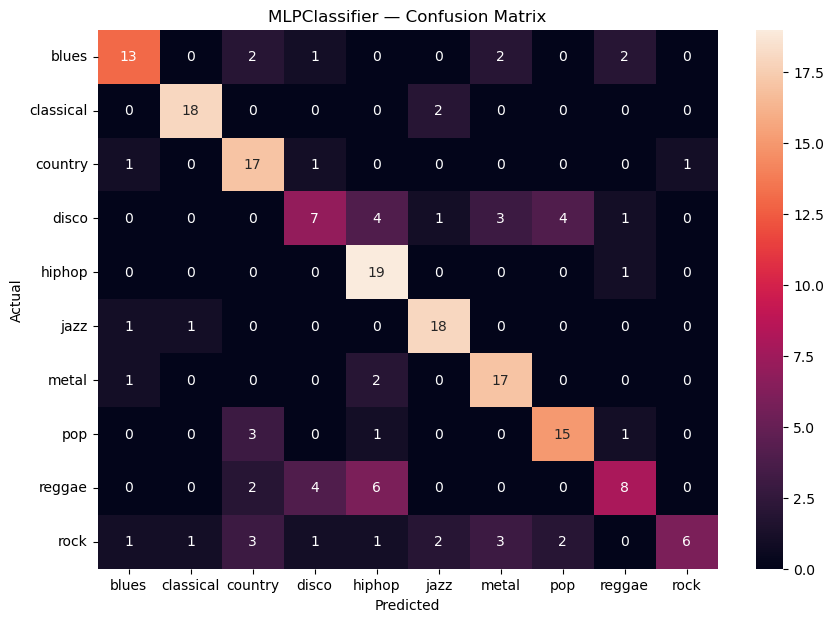

In [20]:

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp.fit(X_train_sc, y_train)

mlp_pred = mlp.predict(X_test_sc)
mlp_acc = accuracy_score(y_test, mlp_pred)
print(f"MLPClassifier Accuracy: {mlp_acc:.4f}")
print("\nMLPClassifier Classification Report:\n", classification_report(y_test, mlp_pred, target_names=le.classes_))

mlp_cm = confusion_matrix(y_test, mlp_pred)
plt.figure(figsize=(10,7))
sns.heatmap(mlp_cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLPClassifier — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:

# Optional: quick cross-validation on the training set (MLP)
# (Uses scaled features)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp, X_train_sc, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
print("MLP 5-fold CV accuracy: mean = %.4f, std = %.4f" % (cv_scores.mean(), cv_scores.std()))


MLP 5-fold CV accuracy: mean = 0.6763, std = 0.0543


In [23]:

# Choose the better test accuracy model
best_model_name = 'MLP' if mlp_acc >= rf_acc else 'RandomForest'
best_model = mlp if best_model_name == 'MLP' else rf
use_scaler = scaler if best_model_name == 'MLP' else None  # RF doesn't need scaling

print(f"\n✅ Best model based on test accuracy: {best_model_name}")

bundle = {
    'model_name': best_model_name,
    'model': best_model,
    'scaler': use_scaler,
    'label_encoder': le,
    'feature_params': {'n_mfcc': 20, 'duration': 30},
    'classes': le.classes_.tolist(),
}

with open('music_genre_model.pkl', 'wb') as f:
    pickle.dump(bundle, f)

print("💾 Saved pickle: music_genre_model.pkl")



✅ Best model based on test accuracy: RandomForest
💾 Saved pickle: music_genre_model.pkl


In [26]:

# 🔮 Inference helper
def predict_genre(pickle_path, audio_path):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)
    model = data['model']
    scaler = data['scaler']
    le = data['label_encoder']
    
    feats = extract_features(audio_path)
    if feats is None:
        raise ValueError("Could not extract features from the given file.")
    feats = feats.reshape(1, -1)
    if scaler is not None:
        feats = scaler.transform(feats)
    pred_idx = model.predict(feats)[0]
    return le.inverse_transform([pred_idx])[0]

# Example prediction (using the earlier example file)
predicted = predict_genre('music_genre_model.pkl', example_file)
print("Example file:", example_file)
print("Predicted genre:", predicted)


Example file: C:\Users\chara\OneDrive\Desktop\sample_project\Music Genre Classification\genres\blues\blues.00000.au
Predicted genre: blues


In [35]:
import os
example_file = r"C:\Users\chara\OneDrive\Desktop\sample_project\Music Genre Classification\genres\rock\rock.00004.au"


if os.path.exists(example_file):
    predicted = predict_genre('music_genre_model.pkl', example_file)
    print("🎵 File:", example_file)
    print("Predicted genre:", predicted)
else:
    print("⚠️ File not found:", example_file)


🎵 File: C:\Users\chara\OneDrive\Desktop\sample_project\Music Genre Classification\genres\rock\rock.00004.au
Predicted genre: rock
